In [65]:
import torch
import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import GloVe
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import tensor
from torch.nn import functional as F
from torchtext.data.functional import to_map_style_dataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 5.  Revisiting the SMS spam dataset (30 Pts. + 5 bonus Pts.)

Remember the SMS spam detection pipeline we built last assignment?  Take your code from that exercise (or write it anew, up to you) and replace the tf-idf embedder with a GloVe embedder. Furthermore, swap the logistic regression with a multilayer perceptron. 

* Reading in the raw data (SMS spam dataset2introduced by Almeida et al. 2011)

In [66]:
# download the dataset
import requests
res = requests.get('http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip')

In [67]:
# write zip to temporary file (needed to unzip)
with open('temp.zip', 'wb') as f:
  f.write(res.content)

# unzip the dataset
with ZipFile('temp.zip') as myzip:
  myzip.extractall()

# create a pandas dataframe of the raw data
df = pd.read_csv('SMSSpamCollection', sep='\t', names=['label', 'text'])

In [68]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [69]:
# convert labels to 0/1
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [70]:
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


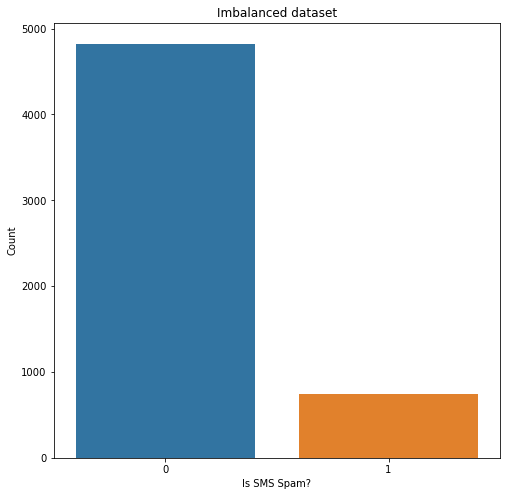

In [71]:
plt.figure(figsize=(8,8))
g = sns.countplot(x='label', data=df)
p = plt.title('Imbalanced dataset')
p = plt.xlabel('Is SMS Spam?')
p = plt.ylabel('Count')

* Randomly splitting the dataset into training (80% of the data) and test (20% of the data).

In [72]:
# split the dataset into train and test with train_test_split from sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['text'].values, df['label'].values, train_size=0.8, test_size=0.2, random_state=42)

In [73]:
# let's 
for i in range(5):
  print(X_train[i], y_train[i])

Reply to win £100 weekly! Where will the 2006 FIFA World Cup be held? Send STOP to 87239 to end service 1
Hello. Sort of out in town already. That . So dont rush home, I am eating nachos. Will let you know eta. 0
How come guoyang go n tell her? Then u told her? 0
Hey sathya till now we dint meet not even a single time then how can i saw the situation sathya. 0
Orange brings you ringtones from all time Chart Heroes, with a free hit each week! Go to Ringtones & Pics on wap. To stop receiving these tips reply STOP. 1


In [20]:
class CustomTextDataset(Dataset):
    def __init__(self, txt, labels):
        self.labels = labels
        self.text = txt
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        label = self.labels[idx]
        text = self.text[idx]
        sample = (text, label)
        return sample

In [21]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)



In [22]:
train_dataset = CustomTextDataset(X_train, y_train)
test_dataset = CustomTextDataset(X_test, y_test)

* Encoding your textual data using aGloVeencoder. To that end use one of the following methodswe discussed during the lecture

In [49]:
# create a GloVe object with 300 dimensions embedding
embed_len = 300
global_vectors = GloVe(name='840B', dim=embed_len)

(a) Mean-pooling: Represents each sentence by the mean of the word embeddings.

(b) Randomized Elman Networks: Represents each sentence by the final hidden state evaluated
considering the Randomized Sentence Embeddings algorithm <br> (note that you have to adjust the spectral radius of the weight matrix corresponding to the hidden state – <br> see the lecture slides for more information). Using this approach correctly earns you5 bonus points.

In [50]:
# tokenizer will split the text into tokens and convert them to lowercase (kind of preprocessing)
tokenizer = get_tokenizer("basic_english")

# (a)
def vectorize_batch(batch):
    
    X, Y = list(zip(*batch))  
    X = [tokenizer(x) for x in X]
    X_tensor = torch.zeros(len(batch), embed_len)
    for i, tokens in enumerate(X):
        tokens_tensor = torch.zeros(embed_len)
        for j, token in enumerate(tokens):
            tokens_tensor += global_vectors.get_vecs_by_tokens(token)
        # calculate mean of all tokens
        tokens_tensor = tokens_tensor / len(tokens)
        X_tensor[i] = tokens_tensor
        
    return X_tensor, torch.tensor(Y) 


# ---------------------------------------- BONUS ---------------------------------------- #
#(b) but the solution for the bonus task dosen't work ;(
def randomized_sentence_embedding(batch_S, embedding, g):

    # randomly initialize A (R^g x R^n) and B (R^g x R^g)
    A = torch.rand(g, len(batch_S))
    B = torch.rand(g, g)
    # W = {}
    W = torch.zeros(len(batch_S), g)
    #for each element S_i = {word1;word2,....,word_T_i} of ¯S do
    for i, S_i in enumerate(batch_S):
        # //intialize the hidden state for the first step
        h_t = 0
        #h_t = torch.zeros(g,1)
        # //for each word_j in S_i do
        for word_j in S_i:
            # //obtain the previously trained word embeddings for wordj
            w_j = embedding(word_j).view(-1, 1)
            # //evaluate the dynamical systems equation for Elman networks
            h_t = torch.tanh(torch.matmul(B, h_t) + torch.matmul(A, w_j)) # let's try with tanh /// something is wrong with the dimensions
        # //set the last hidden state as the embedding of the sentence Si

        W[i] = h_t

    return W

def vectorize_batch_bonus(batch):
    
    X, Y = list(zip(*batch))  
    X = [tokenizer(x) for x in X]
    W = randomized_sentence_embedding(X, embedding=global_vectors.get_vecs_by_tokens, g=300)
        
    return W, torch.tensor(Y) 
# ---------------------------------------- BONUS ---------------------------------------- #

In [51]:
train_loader = DataLoader(train_dataset, batch_size=128, collate_fn=vectorize_batch)
test_loader = DataLoader(test_dataset, batch_size=128, collate_fn=vectorize_batch)

* Training a multilayer perceptron3model on predicting whether the input is spam or ham using only your training set

In [52]:
class SpamClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(embed_len, 256),
            nn.ReLU(),

            nn.Linear(256,128),
            nn.ReLU(),

            nn.Linear(128,64),
            nn.ReLU(),

            nn.Linear(64, 2),
        )

    def forward(self, X_batch):
        return self.classifier(X_batch)

In [53]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            X = X.to(device)
            Y = Y.type(torch.LongTensor)
            Y = Y.to(device)
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)
        val_loss = torch.tensor(losses).mean()
        val_acc = accuracy_score(Y_shuffled.detach().cpu(), Y_preds.detach().cpu())
        print("Valid Loss : {:.3f}".format(val_loss))
        print("Valid Acc  : {:.3f}".format(val_acc))
        return val_loss, val_acc

def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, device, epochs=10):
    train_loss = []
    val_loss = []
    val_acc = []
    for i in range(1, epochs+1):
        losses = []
        
        for X, Y in tqdm(train_loader):
            X = X.to(device)
            Y = Y.type(torch.LongTensor)
            Y = Y.to(device)
            Y_preds = model(X)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss_e = torch.tensor(losses).mean()
        train_loss.append(train_loss_e)

        print("Train Loss : {:.3f}".format(train_loss_e))
        val_loss_e, val_acc_e = CalcValLossAndAccuracy(model, loss_fn, val_loader)
        val_loss.append(val_loss_e)
        val_acc.append(val_acc_e)
        

    return train_loss, val_loss, val_acc
            

* Predicting on your hold-out test set and reporting your achieved accuracy

In [54]:
# We will evaluate our model on the test set after each epoch, so we can see how it improves over time
from torch.optim import Adam

epochs = 10
learning_rate = 7e-4

loss_fn = nn.CrossEntropyLoss()
embed_classifier = SpamClassifier().to(device)
optimizer = Adam(embed_classifier.parameters(), lr=learning_rate)

train_loss, val_loss, val_acc = TrainModel(embed_classifier, loss_fn, optimizer, train_loader, test_loader, device=device, epochs=epochs)

100%|██████████| 35/35 [00:02<00:00, 12.14it/s]


Train Loss : 0.464
Valid Loss : 0.293
Valid Acc  : 0.866


100%|██████████| 35/35 [00:02<00:00, 12.86it/s]


Train Loss : 0.224
Valid Loss : 0.168
Valid Acc  : 0.936


100%|██████████| 35/35 [00:02<00:00, 12.73it/s]


Train Loss : 0.141
Valid Loss : 0.105
Valid Acc  : 0.966


100%|██████████| 35/35 [00:02<00:00, 12.41it/s]


Train Loss : 0.084
Valid Loss : 0.073
Valid Acc  : 0.978


100%|██████████| 35/35 [00:02<00:00, 12.48it/s]


Train Loss : 0.060
Valid Loss : 0.062
Valid Acc  : 0.979


100%|██████████| 35/35 [00:02<00:00, 12.11it/s]


Train Loss : 0.045
Valid Loss : 0.058
Valid Acc  : 0.978


100%|██████████| 35/35 [00:02<00:00, 12.68it/s]


Train Loss : 0.036
Valid Loss : 0.058
Valid Acc  : 0.979


100%|██████████| 35/35 [00:02<00:00, 12.20it/s]


Train Loss : 0.029
Valid Loss : 0.055
Valid Acc  : 0.982


100%|██████████| 35/35 [00:02<00:00, 12.85it/s]


Train Loss : 0.022
Valid Loss : 0.056
Valid Acc  : 0.985


100%|██████████| 35/35 [00:02<00:00, 12.66it/s]


Train Loss : 0.018
Valid Loss : 0.059
Valid Acc  : 0.986


In [62]:
def plot_train_n_eval_metric(train_list, eval_list, mode: str="Loss"):
    assert len(train_list) == len(eval_list)
    x = np.arange(0, len(train_list))
    # plot training and validation loss/accuracy 
    plt.plot(x, train_list, label = f"Training {mode}")
    plt.plot(x, eval_list, label = f"Test {mode}")

    plt.legend()
    plt.show()

def plot_accuracy(val_acc_list):
    x = np.arange(0, len(val_acc_list))
    plt.plot(x, val_acc_list, label = f"Test Accuracy")
    plt.legend()
    plt.show()

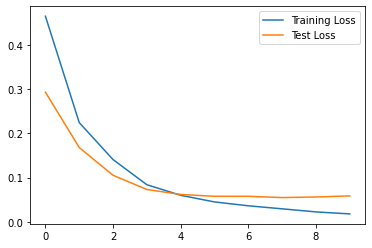

In [63]:
plot_train_n_eval_metric(train_loss, val_loss, mode="Loss")

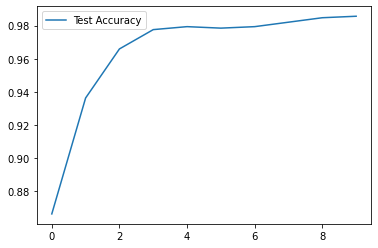

In [64]:
plot_accuracy(val_acc)

* Compare your results to your results from the previous assignment (a tf-idf encoder with either a logistic regression or a k-nearest neighbour search with at least k=3 neighbours).

Our result to the previous assignment:
+ Linear regression: test accuracy = 95%
+ K-Nearest neighbors (k=3): test accuracy = 92%

* The current results of MLP with GloVe (mean pooling): test accuracy = 98.6%

So MLP with GloVe performs better than any of methods from the previous assignment
       